In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
PRINT_EVERY = 100
UPDATE_EVERY = 4

## Set Environment

In [7]:
ENV_NAME = "LunarLander-v2"
env = gym.make(ENV_NAME)

## Build DQN Architecture

In [8]:
class DQN(nn.Module):
    
    def __init__(self, state_size, action_size, seed, fcl_units=64, fc2_units=64):
    
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        self.fc1_layer = nn.Linear(state_size, fcl_units)
        self.fc2_layer = nn.Linear(fcl_units, fc2_units)
        self.fc3_layer = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        state = F.relu(self.fc1_layer(state))
        state = F.relu(self.fc2_layer(state))
        Qsa = self.fc3_layer(state)
        
        return Qsa        

## Set Replay Buffer

In [9]:
class ReplayBuffer(object):
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

## Define [DQN](https://arxiv.org/pdf/1312.5602.pdf) Agent

In [10]:
class DQNAgent():
    
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.dqn_net = DQN(state_size, action_size, seed).to(device)
        self.target_net = DQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.dqn_net.parameters(), lr=LR)
        
        # Replay Buffer
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        self.buffer.add(state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
            
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
        self.dqn_net.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        Q_target_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        Q_expected = self.dqn_net(states).gather(1, actions)
        
        loss = F.mse_loss(Q_target, Q_expected)
        
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)

In [11]:
agent = DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=90)

## Train The Agent

In [12]:
def train_agent(num_episodes, max_time=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, num_episodes+1):
        
        state = env.reset()[0]
        score = 0

        for time_step in range(max_time):
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, info = env.step(action)
            agent.memorize(state, action, reward, next_state, terminated)
            state = next_state
            score += reward
            if terminated or truncated:
                break
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            torch.save(agent.dqn_net.state_dict(), f'./agents/DQN_{ENV_NAME}.pth')
            
    print('Training completed.')
    return scores

env.close()

In [13]:
scores = train_agent(num_episodes=2000, max_time=1000)

Episode: 100, Average Score: -161.09
Episode: 200, Average Score: -93.639
Episode: 300, Average Score: -9.607
Episode: 400, Average Score: 44.68
Episode: 500, Average Score: 116.05
Episode: 600, Average Score: 183.19
Episode: 700, Average Score: 195.91
Episode: 730, Average Score: 202.19
Environment solved in 630 episodes! Average Score: 202.19
Episode: 731, Average Score: 201.73
Environment solved in 631 episodes! Average Score: 201.73
Episode: 732, Average Score: 202.10
Environment solved in 632 episodes! Average Score: 202.10
Episode: 733, Average Score: 201.99
Environment solved in 633 episodes! Average Score: 201.99
Episode: 734, Average Score: 202.22
Environment solved in 634 episodes! Average Score: 202.22
Episode: 735, Average Score: 201.88
Environment solved in 635 episodes! Average Score: 201.88
Episode: 736, Average Score: 202.40
Environment solved in 636 episodes! Average Score: 202.40
Episode: 737, Average Score: 202.37
Environment solved in 637 episodes! Average Score: 20

Episode: 815, Average Score: 217.10
Environment solved in 715 episodes! Average Score: 217.10
Episode: 816, Average Score: 216.41
Environment solved in 716 episodes! Average Score: 216.41
Episode: 817, Average Score: 216.01
Environment solved in 717 episodes! Average Score: 216.01
Episode: 818, Average Score: 216.75
Environment solved in 718 episodes! Average Score: 216.75
Episode: 819, Average Score: 216.73
Environment solved in 719 episodes! Average Score: 216.73
Episode: 820, Average Score: 217.09
Environment solved in 720 episodes! Average Score: 217.09
Episode: 821, Average Score: 217.38
Environment solved in 721 episodes! Average Score: 217.38
Episode: 822, Average Score: 217.52
Environment solved in 722 episodes! Average Score: 217.52
Episode: 823, Average Score: 218.24
Environment solved in 723 episodes! Average Score: 218.24
Episode: 824, Average Score: 218.47
Environment solved in 724 episodes! Average Score: 218.47
Episode: 825, Average Score: 218.85
Environment solved in 72

Episode: 903, Average Score: 222.97
Environment solved in 803 episodes! Average Score: 222.97
Episode: 904, Average Score: 222.88
Environment solved in 804 episodes! Average Score: 222.88
Episode: 905, Average Score: 222.70
Environment solved in 805 episodes! Average Score: 222.70
Episode: 906, Average Score: 223.02
Environment solved in 806 episodes! Average Score: 223.02
Episode: 907, Average Score: 222.92
Environment solved in 807 episodes! Average Score: 222.92
Episode: 908, Average Score: 223.01
Environment solved in 808 episodes! Average Score: 223.01
Episode: 909, Average Score: 223.58
Environment solved in 809 episodes! Average Score: 223.58
Episode: 910, Average Score: 223.84
Environment solved in 810 episodes! Average Score: 223.84
Episode: 911, Average Score: 224.12
Environment solved in 811 episodes! Average Score: 224.12
Episode: 912, Average Score: 224.58
Environment solved in 812 episodes! Average Score: 224.58
Episode: 913, Average Score: 224.42
Environment solved in 81

Episode: 992, Average Score: 218.75
Environment solved in 892 episodes! Average Score: 218.75
Episode: 993, Average Score: 221.55
Environment solved in 893 episodes! Average Score: 221.55
Episode: 994, Average Score: 224.00
Environment solved in 894 episodes! Average Score: 224.00
Episode: 995, Average Score: 224.52
Environment solved in 895 episodes! Average Score: 224.52
Episode: 996, Average Score: 224.43
Environment solved in 896 episodes! Average Score: 224.43
Episode: 997, Average Score: 224.76
Environment solved in 897 episodes! Average Score: 224.76
Episode: 998, Average Score: 225.36
Environment solved in 898 episodes! Average Score: 225.36
Episode: 999, Average Score: 225.07
Environment solved in 899 episodes! Average Score: 225.07
Episode: 1000, Average Score: 225.55

Environment solved in 900 episodes! Average Score: 225.55
Episode: 1001, Average Score: 226.42
Environment solved in 901 episodes! Average Score: 226.42
Episode: 1002, Average Score: 227.18
Environment solved i

Episode: 1079, Average Score: 229.28
Environment solved in 979 episodes! Average Score: 229.28
Episode: 1080, Average Score: 228.55
Environment solved in 980 episodes! Average Score: 228.55
Episode: 1081, Average Score: 227.57
Environment solved in 981 episodes! Average Score: 227.57
Episode: 1082, Average Score: 227.90
Environment solved in 982 episodes! Average Score: 227.90
Episode: 1083, Average Score: 227.98
Environment solved in 983 episodes! Average Score: 227.98
Episode: 1084, Average Score: 227.64
Environment solved in 984 episodes! Average Score: 227.64
Episode: 1085, Average Score: 227.18
Environment solved in 985 episodes! Average Score: 227.18
Episode: 1086, Average Score: 226.94
Environment solved in 986 episodes! Average Score: 226.94
Episode: 1087, Average Score: 227.36
Environment solved in 987 episodes! Average Score: 227.36
Episode: 1088, Average Score: 226.52
Environment solved in 988 episodes! Average Score: 226.52
Episode: 1089, Average Score: 229.15
Environment s

Episode: 1165, Average Score: 239.81
Environment solved in 1065 episodes! Average Score: 239.81
Episode: 1166, Average Score: 239.93
Environment solved in 1066 episodes! Average Score: 239.93
Episode: 1167, Average Score: 239.38
Environment solved in 1067 episodes! Average Score: 239.38
Episode: 1168, Average Score: 239.19
Environment solved in 1068 episodes! Average Score: 239.19
Episode: 1169, Average Score: 239.18
Environment solved in 1069 episodes! Average Score: 239.18
Episode: 1170, Average Score: 239.50
Environment solved in 1070 episodes! Average Score: 239.50
Episode: 1171, Average Score: 239.92
Environment solved in 1071 episodes! Average Score: 239.92
Episode: 1172, Average Score: 240.12
Environment solved in 1072 episodes! Average Score: 240.12
Episode: 1173, Average Score: 239.66
Environment solved in 1073 episodes! Average Score: 239.66
Episode: 1174, Average Score: 239.73
Environment solved in 1074 episodes! Average Score: 239.73
Episode: 1175, Average Score: 240.37
Env

Episode: 1251, Average Score: 245.63
Environment solved in 1151 episodes! Average Score: 245.63
Episode: 1252, Average Score: 245.80
Environment solved in 1152 episodes! Average Score: 245.80
Episode: 1253, Average Score: 246.14
Environment solved in 1153 episodes! Average Score: 246.14
Episode: 1254, Average Score: 245.71
Environment solved in 1154 episodes! Average Score: 245.71
Episode: 1255, Average Score: 245.18
Environment solved in 1155 episodes! Average Score: 245.18
Episode: 1256, Average Score: 244.52
Environment solved in 1156 episodes! Average Score: 244.52
Episode: 1257, Average Score: 245.35
Environment solved in 1157 episodes! Average Score: 245.35
Episode: 1258, Average Score: 245.20
Environment solved in 1158 episodes! Average Score: 245.20
Episode: 1259, Average Score: 245.19
Environment solved in 1159 episodes! Average Score: 245.19
Episode: 1260, Average Score: 244.64
Environment solved in 1160 episodes! Average Score: 244.64
Episode: 1261, Average Score: 244.83
Env

Episode: 1337, Average Score: 239.73
Environment solved in 1237 episodes! Average Score: 239.73
Episode: 1338, Average Score: 239.14
Environment solved in 1238 episodes! Average Score: 239.14
Episode: 1339, Average Score: 239.27
Environment solved in 1239 episodes! Average Score: 239.27
Episode: 1340, Average Score: 238.99
Environment solved in 1240 episodes! Average Score: 238.99
Episode: 1341, Average Score: 238.42
Environment solved in 1241 episodes! Average Score: 238.42
Episode: 1342, Average Score: 238.65
Environment solved in 1242 episodes! Average Score: 238.65
Episode: 1343, Average Score: 235.71
Environment solved in 1243 episodes! Average Score: 235.71
Episode: 1344, Average Score: 236.15
Environment solved in 1244 episodes! Average Score: 236.15
Episode: 1345, Average Score: 235.85
Environment solved in 1245 episodes! Average Score: 235.85
Episode: 1346, Average Score: 236.29
Environment solved in 1246 episodes! Average Score: 236.29
Episode: 1347, Average Score: 235.93
Env

Episode: 1423, Average Score: 241.90
Environment solved in 1323 episodes! Average Score: 241.90
Episode: 1424, Average Score: 242.27
Environment solved in 1324 episodes! Average Score: 242.27
Episode: 1425, Average Score: 242.43
Environment solved in 1325 episodes! Average Score: 242.43
Episode: 1426, Average Score: 242.59
Environment solved in 1326 episodes! Average Score: 242.59
Episode: 1427, Average Score: 242.81
Environment solved in 1327 episodes! Average Score: 242.81
Episode: 1428, Average Score: 243.10
Environment solved in 1328 episodes! Average Score: 243.10
Episode: 1429, Average Score: 240.90
Environment solved in 1329 episodes! Average Score: 240.90
Episode: 1430, Average Score: 241.12
Environment solved in 1330 episodes! Average Score: 241.12
Episode: 1431, Average Score: 242.59
Environment solved in 1331 episodes! Average Score: 242.59
Episode: 1432, Average Score: 243.95
Environment solved in 1332 episodes! Average Score: 243.95
Episode: 1433, Average Score: 244.17
Env

Episode: 1509, Average Score: 246.66
Environment solved in 1409 episodes! Average Score: 246.66
Episode: 1510, Average Score: 246.71
Environment solved in 1410 episodes! Average Score: 246.71
Episode: 1511, Average Score: 246.82
Environment solved in 1411 episodes! Average Score: 246.82
Episode: 1512, Average Score: 246.85
Environment solved in 1412 episodes! Average Score: 246.85
Episode: 1513, Average Score: 246.86
Environment solved in 1413 episodes! Average Score: 246.86
Episode: 1514, Average Score: 246.65
Environment solved in 1414 episodes! Average Score: 246.65
Episode: 1515, Average Score: 246.62
Environment solved in 1415 episodes! Average Score: 246.62
Episode: 1516, Average Score: 246.80
Environment solved in 1416 episodes! Average Score: 246.80
Episode: 1517, Average Score: 246.83
Environment solved in 1417 episodes! Average Score: 246.83
Episode: 1518, Average Score: 246.69
Environment solved in 1418 episodes! Average Score: 246.69
Episode: 1519, Average Score: 246.73
Env

Episode: 1596, Average Score: 253.72
Environment solved in 1496 episodes! Average Score: 253.72
Episode: 1597, Average Score: 253.73
Environment solved in 1497 episodes! Average Score: 253.73
Episode: 1598, Average Score: 253.97
Environment solved in 1498 episodes! Average Score: 253.97
Episode: 1599, Average Score: 254.02
Environment solved in 1499 episodes! Average Score: 254.02
Episode: 1600, Average Score: 254.51

Environment solved in 1500 episodes! Average Score: 254.51
Episode: 1601, Average Score: 254.17
Environment solved in 1501 episodes! Average Score: 254.17
Episode: 1602, Average Score: 254.06
Environment solved in 1502 episodes! Average Score: 254.06
Episode: 1603, Average Score: 253.94
Environment solved in 1503 episodes! Average Score: 253.94
Episode: 1604, Average Score: 253.75
Environment solved in 1504 episodes! Average Score: 253.75
Episode: 1605, Average Score: 254.01
Environment solved in 1505 episodes! Average Score: 254.01
Episode: 1606, Average Score: 253.91
En

Episode: 1683, Average Score: 251.96
Environment solved in 1583 episodes! Average Score: 251.96
Episode: 1684, Average Score: 252.10
Environment solved in 1584 episodes! Average Score: 252.10
Episode: 1685, Average Score: 252.06
Environment solved in 1585 episodes! Average Score: 252.06
Episode: 1686, Average Score: 251.86
Environment solved in 1586 episodes! Average Score: 251.86
Episode: 1687, Average Score: 251.52
Environment solved in 1587 episodes! Average Score: 251.52
Episode: 1688, Average Score: 251.38
Environment solved in 1588 episodes! Average Score: 251.38
Episode: 1689, Average Score: 251.26
Environment solved in 1589 episodes! Average Score: 251.26
Episode: 1690, Average Score: 251.15
Environment solved in 1590 episodes! Average Score: 251.15
Episode: 1691, Average Score: 251.63
Environment solved in 1591 episodes! Average Score: 251.63
Episode: 1692, Average Score: 251.56
Environment solved in 1592 episodes! Average Score: 251.56
Episode: 1693, Average Score: 251.68
Env

Episode: 1770, Average Score: 257.71
Environment solved in 1670 episodes! Average Score: 257.71
Episode: 1771, Average Score: 257.96
Environment solved in 1671 episodes! Average Score: 257.96
Episode: 1772, Average Score: 258.13
Environment solved in 1672 episodes! Average Score: 258.13
Episode: 1773, Average Score: 258.44
Environment solved in 1673 episodes! Average Score: 258.44
Episode: 1774, Average Score: 258.63
Environment solved in 1674 episodes! Average Score: 258.63
Episode: 1775, Average Score: 258.46
Environment solved in 1675 episodes! Average Score: 258.46
Episode: 1776, Average Score: 258.59
Environment solved in 1676 episodes! Average Score: 258.59
Episode: 1777, Average Score: 258.50
Environment solved in 1677 episodes! Average Score: 258.50
Episode: 1778, Average Score: 258.31
Environment solved in 1678 episodes! Average Score: 258.31
Episode: 1779, Average Score: 258.67
Environment solved in 1679 episodes! Average Score: 258.67
Episode: 1780, Average Score: 258.55
Env

Episode: 1856, Average Score: 256.99
Environment solved in 1756 episodes! Average Score: 256.99
Episode: 1857, Average Score: 257.63
Environment solved in 1757 episodes! Average Score: 257.63
Episode: 1858, Average Score: 260.50
Environment solved in 1758 episodes! Average Score: 260.50
Episode: 1859, Average Score: 260.64
Environment solved in 1759 episodes! Average Score: 260.64
Episode: 1860, Average Score: 260.84
Environment solved in 1760 episodes! Average Score: 260.84
Episode: 1861, Average Score: 260.74
Environment solved in 1761 episodes! Average Score: 260.74
Episode: 1862, Average Score: 260.52
Environment solved in 1762 episodes! Average Score: 260.52
Episode: 1863, Average Score: 260.37
Environment solved in 1763 episodes! Average Score: 260.37
Episode: 1864, Average Score: 260.89
Environment solved in 1764 episodes! Average Score: 260.89
Episode: 1865, Average Score: 260.43
Environment solved in 1765 episodes! Average Score: 260.43
Episode: 1866, Average Score: 260.59
Env

Episode: 1942, Average Score: 252.52
Environment solved in 1842 episodes! Average Score: 252.52
Episode: 1943, Average Score: 252.53
Environment solved in 1843 episodes! Average Score: 252.53
Episode: 1944, Average Score: 252.59
Environment solved in 1844 episodes! Average Score: 252.59
Episode: 1945, Average Score: 252.75
Environment solved in 1845 episodes! Average Score: 252.75
Episode: 1946, Average Score: 253.42
Environment solved in 1846 episodes! Average Score: 253.42
Episode: 1947, Average Score: 253.85
Environment solved in 1847 episodes! Average Score: 253.85
Episode: 1948, Average Score: 253.57
Environment solved in 1848 episodes! Average Score: 253.57
Episode: 1949, Average Score: 253.84
Environment solved in 1849 episodes! Average Score: 253.84
Episode: 1950, Average Score: 253.75
Environment solved in 1850 episodes! Average Score: 253.75
Episode: 1951, Average Score: 254.03
Environment solved in 1851 episodes! Average Score: 254.03
Episode: 1952, Average Score: 253.89
Env

## Evaluate The Agent

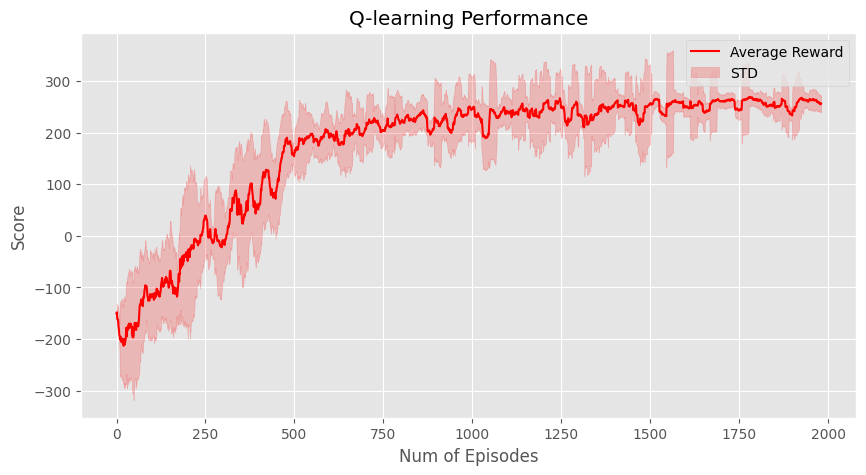

In [14]:
window_size = 20
rolling_mean = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
std_dev = np.array([np.std(scores[max(0, i-window_size+1):i+1]) for i in range(len(scores))])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(rolling_mean)), rolling_mean, color='red', label='Average Reward')
plt.fill_between(np.arange(len(rolling_mean)), rolling_mean-std_dev[:len(rolling_mean)], rolling_mean+std_dev[:len(rolling_mean)], color='red', alpha=0.2, label='STD')
plt.xlabel('Num of Episodes')
plt.ylabel('Score')
plt.title('Q-learning Performance')
plt.legend()
plt.show()

## Observe Agent

In [15]:
agent.dqn_net.load_state_dict(torch.load(f'./agents/DQN_{ENV_NAME}.pth'));

In [16]:
env = gym.make(ENV_NAME, render_mode='human')

def evaluate_agent(agent, env, num_episodes=5, max_time=1000):
    
    for i_episode in range(1, num_episodes+1):

        state = env.reset()[0]
        score = 0

        for time_step in range(max_time):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
            score += reward

            env.render() 

            if terminated or truncated:
                break

        print(f'Episode: {i_episode}, Score: {score}')

    env.close()
    print('Evaluation completed.')

evaluate_agent(agent, env, num_episodes=5)

Episode: 1, Score: 226.51686615751305
Episode: 2, Score: 269.44083003981916
Episode: 3, Score: 237.07285375295277
Episode: 4, Score: 251.38806295844313
Episode: 5, Score: 280.5096638096554
Evaluation completed.


---